# Concise representations with the deep decoder

We demonstrate the the deep decoder enables concise representations of images. Towards this goal, we represent an image with an underparametrized deep decoder with $N$ parameters, and for comparison with a wavelet respresentation that retains the $N$ largest wavelet coefficients (i.e., wavelet thresholding). 

We find that if $N$ is small relative to the number of output pixels, the deep decoder performs better (i.e., has smaller representation error).

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
import numpy as np
import numbers
import pywt
import scipy
import skimage.color as color
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import os
from PIL import Image
import PIL
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.optim
from torch.autograd import Variable

from include import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("num GPUs",torch.cuda.device_count())
#dtype = torch.FloatTensor

num GPUs 1


## Functions to compute the representation error

In [ ]:
def rep_error_deep_decoder(img_np,k=128,convert2ycbcr=False,OPTIMIZER='adam',lr=0.005):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)
    rnd = 500
    numit = 10000
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=lr,
                        OPTIMIZER=OPTIMIZER,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net), mse_n, mse_t

def rep_error_wavelet(img_np,ncoeff=300):
    '''
    mse obtained by representing img_np with wavelet thresholding
    ncoff coefficients are retained per color channel
    '''
    if img_np.shape[0] == 1:
        img_np = img_np[0,:,:]
        out_img_np = denoise_wavelet(img_np, ncoeff=ncoeff, multichannel=False, convert2ycbcr=True, mode='hard')
    else:
        img_np = np.transpose(img_np)
        out_img_np = denoise_wavelet(img_np, ncoeff=ncoeff, multichannel=True, convert2ycbcr=True, mode='hard')
    # img_np = np.array([img_np[:,:,0],img_np[:,:,1],img_np[:,:,2]])
    return psnr(out_img_np,img_np), out_img_np

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
def comparison(img_np,k,convert2ycbcr=False,OPTIMIZER='adam',lr=0.005):
    # compute representations
    psnrv, out_img_np, nparms, mse_n, mse_t = rep_error_deep_decoder(img_np,k=k,convert2ycbcr=convert2ycbcr,OPTIMIZER=OPTIMIZER,lr=lr)
    nchannels = img_np.shape[0]
    #psnrv_wvl, out_img_np_wvl = rep_error_wavelet(img_np,ncoeff=int(nparms/nchannels))
    
    print("Compression factor: ", np.prod( img_np.shape ) / nparms )
    # plot results
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1,img_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2,out_img_np)
    ax2.set_title( "Deep-Decoder representation, PSNR: %.2f" % psnrv )
    ax2.axis('off')
    #save_np_img(img_np,"exp_comp_orig.png")
    #save_np_img(out_img_np,"exp_comp_dd.png")

    #ax3 = fig.add_subplot(133)
    #ax3.set_title( "Wavelet representation, PSNR: %.2f" % psnrv_wvl ) 
    #ax3.axis('off')
    
    #if(img_np.shape[0] == 1):
     #   ax3.imshow(np.clip(out_img_np_wvl,0,1),cmap='Greys',interpolation='nearest')
    #else:
    #    ax3.imshow(np.clip(out_img_np_wvl.transpose(1, 0, 2) ,0,1))
    
    plt.axis('off')
    fig.show()
    return mse_n, mse_t

In [11]:
def conv(in_f, out_f, kernel_size, stride=1, pad='zero'):
    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        #to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=False)

    layers = filter(lambda x: x is not None, [padder, convolver])
    return nn.Sequential(*layers)

k=64
num_channels = [k]*5
net = decodernw(3,num_channels_up=num_channels).type(dtype)
#print(net)

## Representation error for a color image

The deep decoder performs similarly well when applied to an RGB encoded color image and an YCbCr-encoded image.  In the following experiments, the deep decoder has either k=64 or k=128 channels, and operates on either a RGB or a YCbCr image representation. Wavelet compression performs better in YCbCr space; therefore, we always compare to wavelet thresholding of a YCbCr-encoded image. 

The results show that typically, for a large compression factor, defined as number of output pixels over the number of parameters of the representations, the deep decoder performs better than wavelet thresholding in that it has a smaller representation error. For small compression factors, wavelet thresholding has a smaller representation error.



In [17]:
k=64
num_channels = [k]*5
net = decodernw(3,num_channels_up=num_channels).type(dtype)
#print(net)

path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

mse_n_sgd, mse_t_sgd = comparison(img_np,64,convert2ycbcr=False,OPTIMIZER='SGD')

shape:  [1, 64, 16, 16]
optimize with SGD 0.005
Compression factor:  30.796992481203006 Actual loss 0.011728 Actual loss orig 0.011718  Noise Energy 0.000000 


shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.003641 Actual loss orig 0.003641  Noise Energy 0.000000 


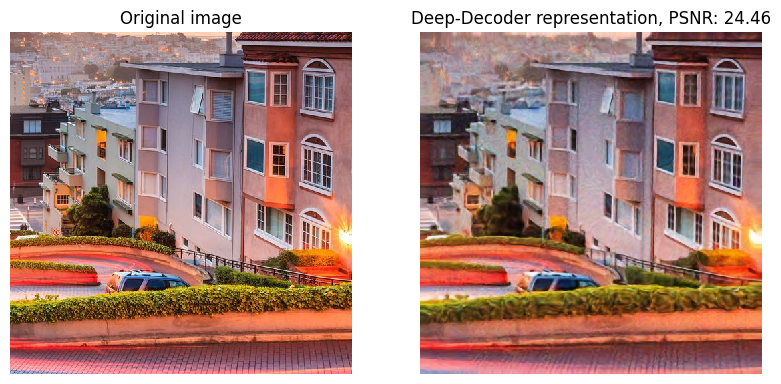

In [12]:
k=64
num_channels = [k]*5
net = decodernw(3,num_channels_up=num_channels).type(dtype)
#print(net)

path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

mse_n_adam, mse_t_adam = comparison(img_np,64,convert2ycbcr=False,OPTIMIZER='adam',lr=0.005)

In [20]:
k=64
num_channels = [k]*5
net = decodernw(3,num_channels_up=num_channels).type(dtype)
#print(net)

path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

mse_n_sophia, mse_t_sophia = comparison(img_np,64,convert2ycbcr=False,OPTIMIZER='SophiaG',lr=0.01)

shape:  [1, 64, 16, 16]
optimize with SophiaG
Compression factor:  30.796992481203006 Actual loss 0.003574 Actual loss orig 0.003574  Noise Energy 0.000000 


shape:  [1, 64, 16, 16]
optimize with Optimistic Mirror Descent
Compression factor:  30.796992481203006 Actual loss 0.004644 Actual loss orig 0.004635  Noise Energy 0.000000 


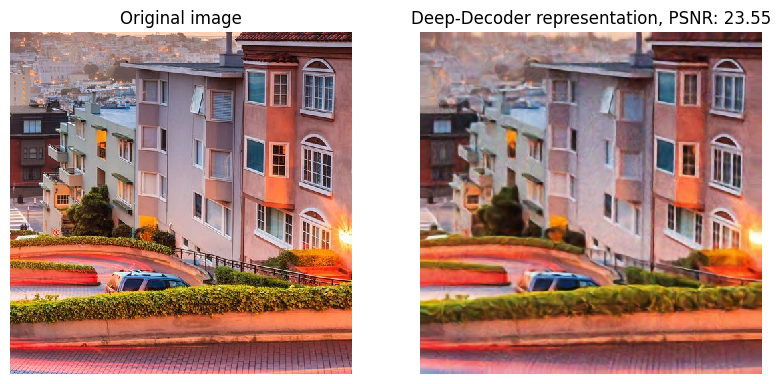

In [20]:
k=64
num_channels = [k]*5
net = decodernw(3,num_channels_up=num_channels).type(dtype)
#print(net)

path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

mse_n_omd, mse_t_omd = comparison(img_np,64,convert2ycbcr=False,OPTIMIZER='OMD')

Text(0, 0.5, 'Net Mean Square Error')

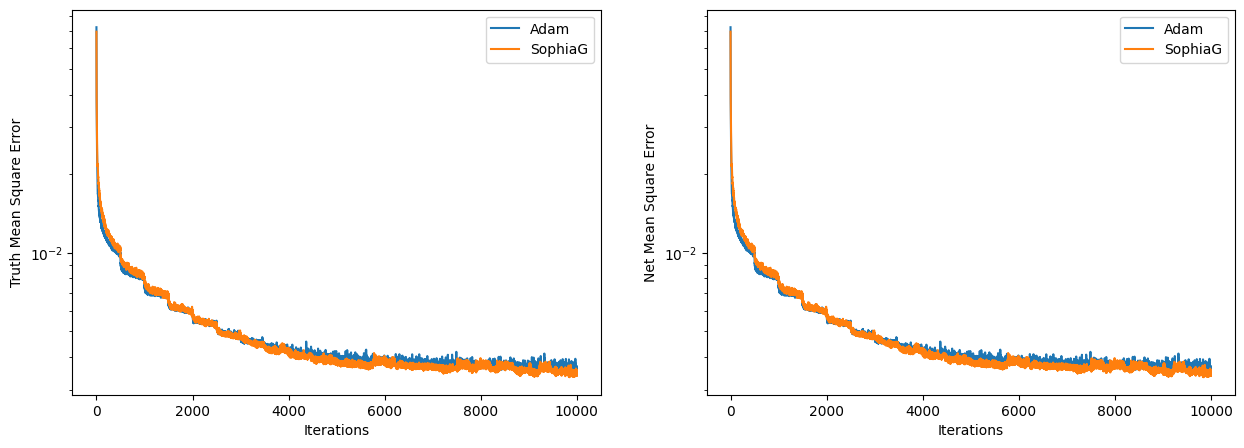

In [21]:
fig = plt.figure(figsize = (15,5)) 
#fig.settitle('Convergence Analysis')

ax1 = fig.add_subplot(121)
#ax1.semilogy(mse_t_sgd,label="SGD")
ax1.semilogy(mse_t_adam,label="Adam")
#ax1.semilogy(mse_t_lbfgs)
ax1.semilogy(mse_t_sophia,label="SophiaG")
#ax1.semilogy(mse_t_sophiah,label="SophiaH")

#ax1.semilogy(mse_t_omd,label="OMD")
ax1.legend(['Adam','SophiaG'])
#ax1.legend(['SGD','Adam','Sophia','OMD'])

ax2 = fig.add_subplot(122)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Truth Mean Square Error')
#ax2.semilogy(mse_n_sgd,label="SGD")
ax2.semilogy(mse_n_adam,label="Adam")
#ax2.semilogy(mse_n_lbfgs)
ax2.semilogy(mse_n_sophia,label="SophiaG")
#ax2.semilogy(mse_n_sophiah,label="SophiaH")

#ax2.semilogy(mse_n_omd,label="OMD")
ax2.legend(['Adam','SophiaG'])
#ax2.legend(['SGD','Adam','Sophia','OMD'])

ax2.set_xlabel('Iterations')
ax2.set_ylabel('Net Mean Square Error')

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.001210 Actual loss orig 0.001210  Noise Energy 0.000000 


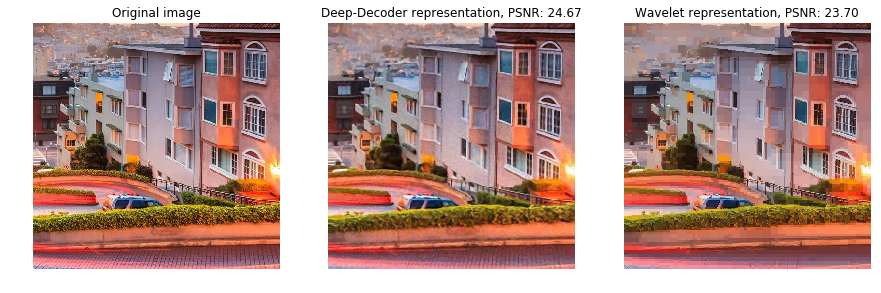

In [ ]:
mse_n_sgd, mse_t_sgd = comparison(img_np,64,convert2ycbcr=True,'SGD')

shape:  [1, 128, 16, 16]
optimize with SGD 0.005
Compression factor:  7.846743295019157  Actual loss 0.008977 Actual loss orig 0.008966  Noise Energy 0.000000 
shape:  [1, 128, 16, 16]
optimize with adam 0.005
Compression factor:  7.846743295019157  Actual loss 0.002061 Actual loss orig 0.002047  Noise Energy 0.000000 
shape:  [1, 128, 16, 16]
optimize with Sophia
Compression factor:  7.846743295019157  Actual loss 0.002209 Actual loss orig 0.002201  Noise Energy 0.000000 
shape:  [1, 128, 16, 16]
optimize with Optimistic Mirror Descent
Compression factor:  7.846743295019157  Actual loss 0.002798 Actual loss orig 0.002786  Noise Energy 0.000000 


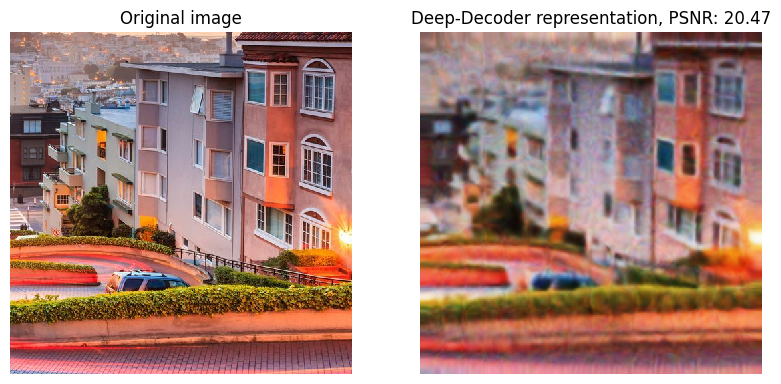

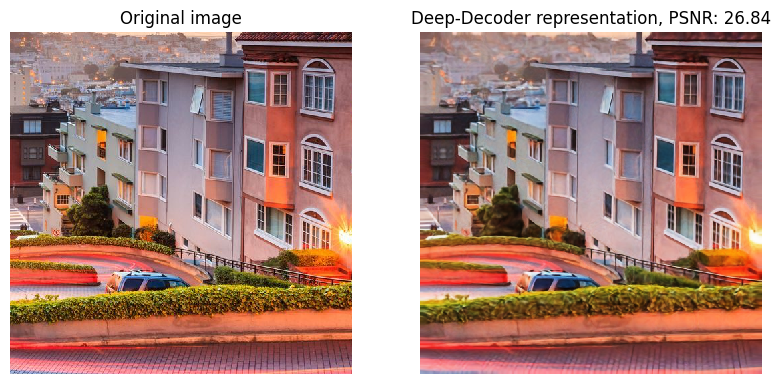

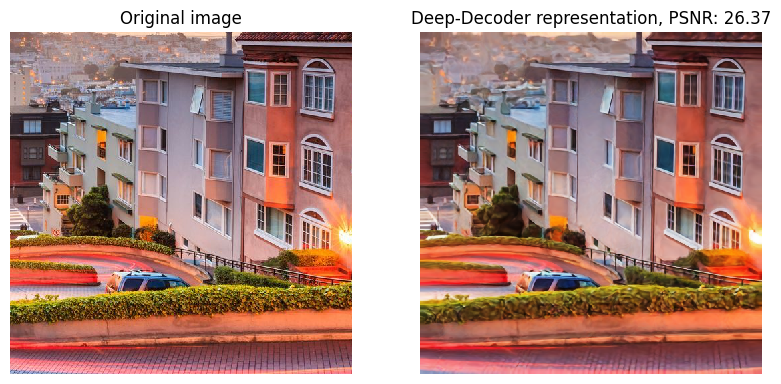

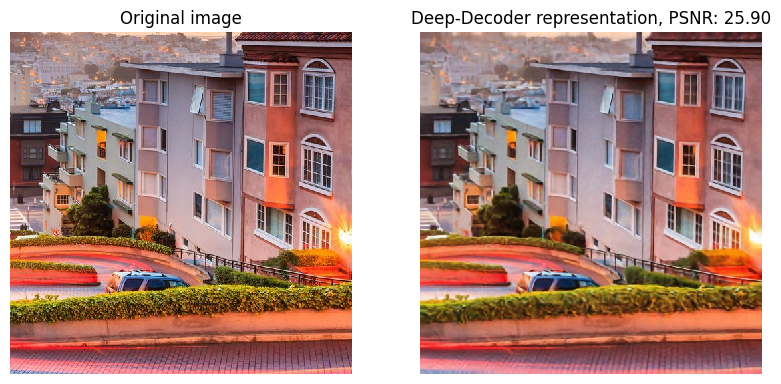

In [23]:
mse_n_sgd, mse_t_sgd = comparison(img_np,128,convert2ycbcr=False,OPTIMIZER='SGD')
mse_n_adam, mse_t_adam = comparison(img_np,128,convert2ycbcr=False,OPTIMIZER='adam')
mse_n_sophia, mse_t_sophia = comparison(img_np,128,convert2ycbcr=False,OPTIMIZER='Sophia')
mse_n_omd, mse_t_omd = comparison(img_np,128,convert2ycbcr=False,OPTIMIZER='OMD')

Text(0, 0.5, 'Net Mean Square Error')

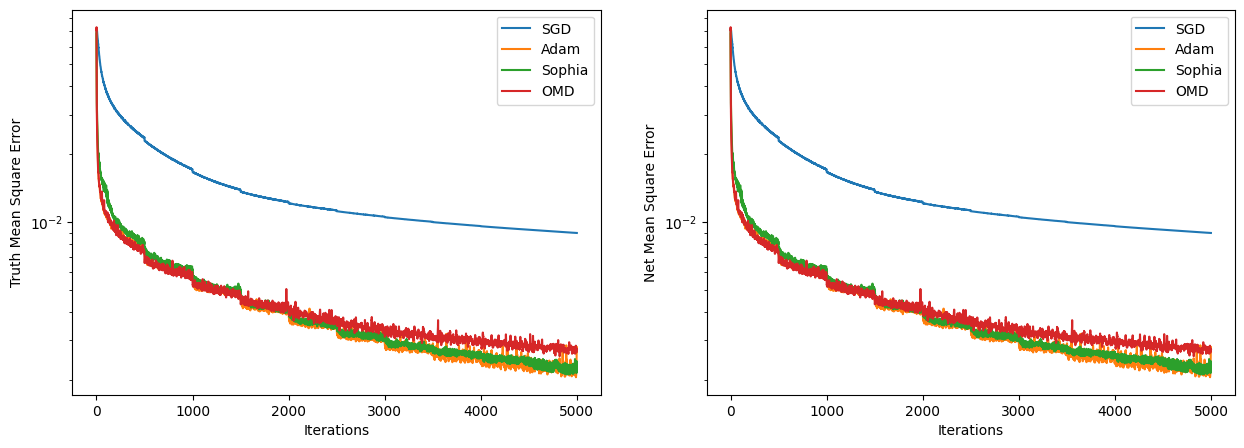

In [24]:
fig = plt.figure(figsize = (15,5)) 
#fig.settitle('Convergence Analysis')

ax1 = fig.add_subplot(121)
ax1.semilogy(mse_t_sgd,label="SGD")
ax1.semilogy(mse_t_adam,label="Adam")
#ax1.semilogy(mse_t_lbfgs)
ax1.semilogy(mse_t_sophia,label="Sophia")
ax1.semilogy(mse_t_omd,label="OMD")
ax1.legend(['SGD','Adam','Sophia','OMD'])
ax2 = fig.add_subplot(122)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Truth Mean Square Error')
ax2.semilogy(mse_n_sgd,label="SGD")
ax2.semilogy(mse_n_adam,label="Adam")
#ax2.semilogy(mse_n_lbfgs)
ax2.semilogy(mse_n_sophia,label="Sophia")
ax2.semilogy(mse_n_omd,label="OMD")
ax2.legend(['SGD','Adam','Sophia','OMD'])
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Net Mean Square Error')

shape:  [1, 128, 16, 16]
optimize with adam 0.005
Compression factor:  7.846743295019157  Actual loss 0.000518 Actual loss orig 0.000518  Noise Energy 0.000000 


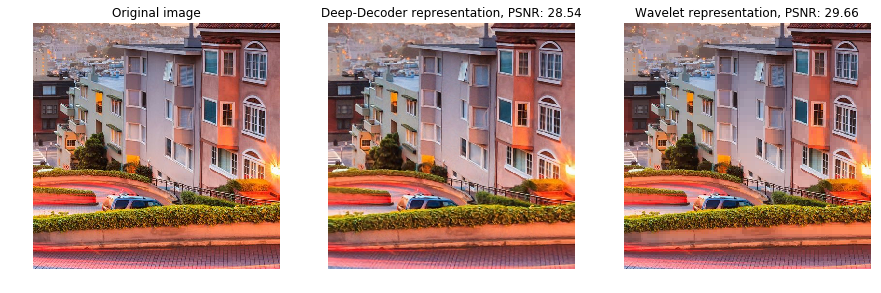

In [ ]:
comparison(img_np,128,convert2ycbcr=True)

## Representation error for a grayscale image

In [22]:
path = './test_data/'
img_name = "mri"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

shape:  [1, 32, 16, 16]
optimize with SophiaG
Compression factor:  39.96097560975615  Actual loss 0.001295 Actual loss orig 0.001295  Noise Energy 0.000000 
shape:  [1, 32, 16, 16]
optimize with adam 0.005
Compression factor:  39.96097560975616  Actual loss 0.001356 Actual loss orig 0.001356  Noise Energy 0.000000 


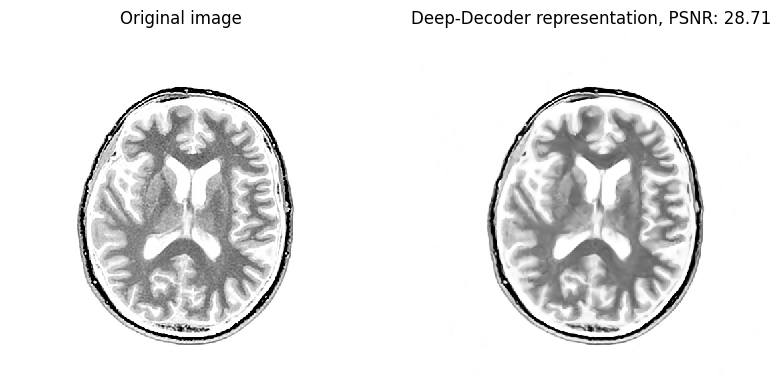

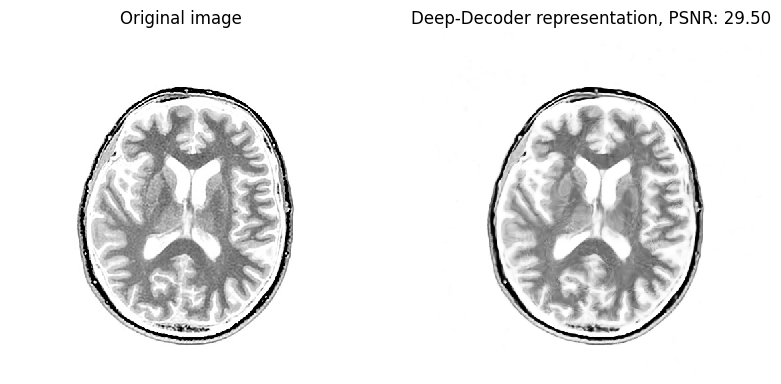

In [23]:
mse_n_sophia, mse_t_sophia = comparison(img_np,32,OPTIMIZER='SophiaG',lr=0.01)
mse_n_adam, mse_t_adam = comparison(img_np,32,OPTIMIZER='adam')

In [24]:
fig = plt.figure(figsize = (15,5)) 
#fig.settitle('Convergence Analysis')

ax1 = fig.add_subplot(121)
#ax1.semilogy(mse_t_sgd,label="SGD")
ax1.semilogy(mse_t_adam,label="Adam")
#ax1.semilogy(mse_t_lbfgs)
ax1.semilogy(mse_t_sophia,label="SophiaG")
#ax1.semilogy(mse_t_sophiah,label="SophiaH")

#ax1.semilogy(mse_t_omd,label="OMD")
ax1.legend(['Adam','SophiaG'])
#ax1.legend(['SGD','Adam','Sophia','OMD'])

ax2 = fig.add_subplot(122)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Truth Mean Square Error')
#ax2.semilogy(mse_n_sgd,label="SGD")
ax2.semilogy(mse_n_adam,label="Adam")
#ax2.semilogy(mse_n_lbfgs)
ax2.semilogy(mse_n_sophia,label="SophiaG")
#ax2.semilogy(mse_n_sophiah,label="SophiaH")

#ax2.semilogy(mse_n_omd,label="OMD")
ax2.legend(['Adam','SophiaG'])
#ax2.legend(['SGD','Adam','Sophia','OMD'])

ax2.set_xlabel('Iterations')
ax2.set_ylabel('Net Mean Square Error')

Text(0, 0.5, 'Net Mean Square Error')

shape:  [1, 64, 16, 16]
optimize with SophiaG
Compression factor:  10.317380352644836 Actual loss 0.000392 Actual loss orig 0.000392  Noise Energy 0.000000 
shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  10.317380352644836 Actual loss 0.000720 Actual loss orig 0.000720  Noise Energy 0.000000 


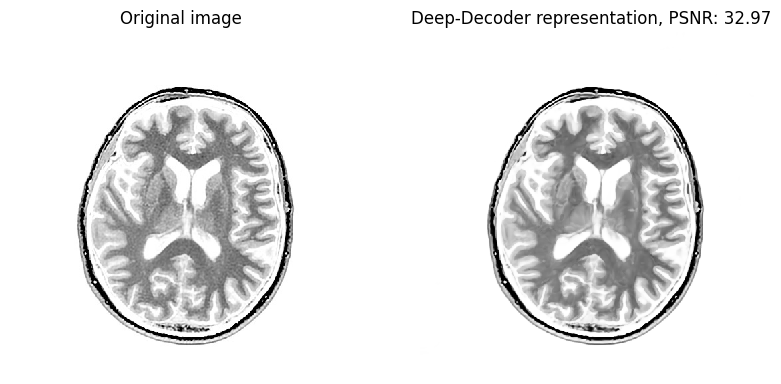

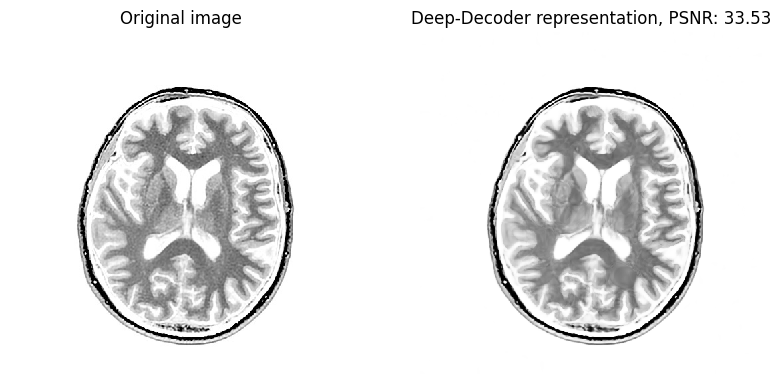

In [25]:
mse_n_sophia, mse_t_sophia = comparison(img_np,64,OPTIMIZER='SophiaG',lr=0.001)
mse_n_adam, mse_t_adam = comparison(img_np,64,OPTIMIZER='adam')

In [ ]:
fig = plt.figure(figsize = (15,5)) 
#fig.settitle('Convergence Analysis')

ax1 = fig.add_subplot(121)
#ax1.semilogy(mse_t_sgd,label="SGD")
ax1.semilogy(mse_t_adam,label="Adam")
#ax1.semilogy(mse_t_lbfgs)
ax1.semilogy(mse_t_sophia,label="SophiaG")
#ax1.semilogy(mse_t_sophiah,label="SophiaH")

#ax1.semilogy(mse_t_omd,label="OMD")
ax1.legend(['Adam','SophiaG'])
#ax1.legend(['SGD','Adam','Sophia','OMD'])

ax2 = fig.add_subplot(122)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Truth Mean Square Error')
#ax2.semilogy(mse_n_sgd,label="SGD")
ax2.semilogy(mse_n_adam,label="Adam")
#ax2.semilogy(mse_n_lbfgs)
ax2.semilogy(mse_n_sophia,label="SophiaG")
#ax2.semilogy(mse_n_sophiah,label="SophiaH")

#ax2.semilogy(mse_n_omd,label="OMD")
ax2.legend(['Adam','SophiaG'])
#ax2.legend(['SGD','Adam','Sophia','OMD'])

ax2.set_xlabel('Iterations')
ax2.set_ylabel('Net Mean Square Error')

shape:  [1, 64, 16, 16]
optimize with adam 0.005
